
Voor Later voor de kleine app
---


Alle nodige imports toevoeegen

In [19]:
import os
import shutil
import random
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import gradio as gr

In [ ]:
!unzip -qq /content/drive/MyDrive/dataset_2Painters_organized.zip

replace dataset_2Painters_organized/test/Mondriaan/1_0002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Dataset Organizatie Script
Dit script organiseert een verzameling afbeeldingen van twee kunstenaars (Mondriaan en Picasso)
in een train/validation/test structuur (70%/15%/15% verdeling) voor machine learning.
De originele afbeeldingen blijven intact; er worden kopieën gemaakt in de nieuwe mappenstructuur.

In [24]:
# Define your directories
original_dir = "dataset_2Painters"  # Your main dataset directory
new_base_dir = "dataset_2Painters_organized"  # Where to put the organized data

# Define the categories (artists in your case)
artists = ('Mondriaan', 'Picasso')
subsets = ('train', 'validation', 'test')

# Create directories
for subset in subsets:
    for artist in artists:
        os.makedirs(os.path.join(new_base_dir, subset, artist), exist_ok=True)

# Process each artist separately to maintain balanced ratios
for artist in artists:
    artist_dir = os.path.join(original_dir, artist)
    if not os.path.exists(artist_dir):
        print(f"Warning: Directory {artist_dir} not found!")
        continue

    # Get files for this artist
    files = os.listdir(artist_dir)
    random.seed(42)  # For reproducibility
    random.shuffle(files)

    # Calculate split points
    total = len(files)
    train_end = int(0.7 * total)
    val_end = int(0.85 * total)

    # Split into subsets
    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

    # Copy files to their respective directories
    for filename in train_files:
        shutil.copy2(os.path.join(artist_dir, filename),
                    os.path.join(new_base_dir, 'train', artist, filename))

    for filename in val_files:
        shutil.copy2(os.path.join(artist_dir, filename),
                    os.path.join(new_base_dir, 'validation', artist, filename))

    for filename in test_files:
        shutil.copy2(os.path.join(artist_dir, filename),
                    os.path.join(new_base_dir, 'test', artist, filename))

    print(f"{artist}: Split {len(train_files)} train, {len(val_files)} validation, {len(test_files)} test")

# Check results
for subset in subsets:
    for artist in artists:
        print(subset, artist, ':', len(os.listdir(os.path.join(new_base_dir, subset, artist))))

train Mondriaan : 188
train Picasso : 900
validation Mondriaan : 40
validation Picasso : 193
test Mondriaan : 41
test Picasso : 194


Controleer mappen structuur

Dataset Verificatie Script
Dit script controleert en toont het aantal afbeeldingen per categorie in de georganiseerde 
dataset structuur voor Mondriaan en Picasso. Het script rapporteert hoeveel bestanden 
er aanwezig zijn in elke train/validation/test subset voor beide kunstenaars.

In [ ]:
# Define your directories - use the organized structure
original_dir = "dataset_2Painters_organized"

# Define the structure for your painters dataset
subsets = ('train', 'validation', 'test')  # Common practice to list train first
artists = ('Mondriaan', 'Picasso')  # Your artist categories instead of animals

# Check and print file counts for each subset and artist
for subset in subsets:
    for artist in artists:
        path = os.path.join(original_dir, subset, artist)
        if os.path.exists(path):
            print(subset, artist, ':', len(os.listdir(path)))
        else:
            print(subset, artist, ': directory not found -', path)

train Mondriaan : 188
train Picasso : 900
validation Mondriaan : 40
validation Picasso : 193
test Mondriaan : 41
test Picasso : 194


CNN Model voor Kunstenaar Classificatie
Dit model classificeert afbeeldingen (180x180 pixels) als Mondriaan of Picasso.
Architectuur: 5 Conv2D lagen met toenemende filter counts (32→64→128→256→256),
MaxPooling na elke laag (behalve de laatste), en een sigmoid output voor binaire classificatie.

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1/.255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [27]:
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

In [28]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, "train"),
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, "validation"),
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, "test"),
    image_size=(180, 180),
    batch_size=32)

Found 1088 files belonging to 2 classes.
Found 233 files belonging to 2 classes.
Found 235 files belonging to 2 classes.


In [29]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [30]:
print(type(train_dataset))
print(type(validation_dataset))
print(type(test_dataset))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [31]:
import numpy as np
import tensorflow as tf

random_numbers = np.random.normal(size=(1000, 16))  # random normaal verdeelde getallen
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(16,), dtype=tf.float64, name=None)>

In [33]:
# de data batchen
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2: break

(32, 16)
(32, 16)
(32, 16)


In [34]:
# map() toepassen om data te reshapen van (16, ) naar (4, 4)
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2: break

(4, 4)
(4, 4)
(4, 4)


In [35]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch.keras",  # file waarin model wordt opgeslagen
    save_best_only=True,
    monitor="val_loss")
]

In [36]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 258ms/step - accuracy: 0.6220 - loss: 436.7524 - val_accuracy: 0.8498 - val_loss: 0.4180
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.7396 - loss: 0.6959 - val_accuracy: 0.8412 - val_loss: 0.3856
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.6836 - loss: 4.4592 - val_accuracy: 0.8541 - val_loss: 0.3704
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.7695 - loss: 0.6245 - val_accuracy: 0.8283 - val_loss: 0.4627
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.7653 - loss: 0.7962 - val_accuracy: 0.4893 - val_loss: 0.7061
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.7550 - loss: 0.5404 - val_accuracy: 0.8498 - val_loss: 0.3266
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.8048 - loss: 0.7099 - val_accuracy: 0.8584 - val_loss: 0.3184
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.8127 - loss: 0.4574 - val_accura

In [37]:
import h5py
h5py.is_hdf5("convnet_from_scratch.keras")

False

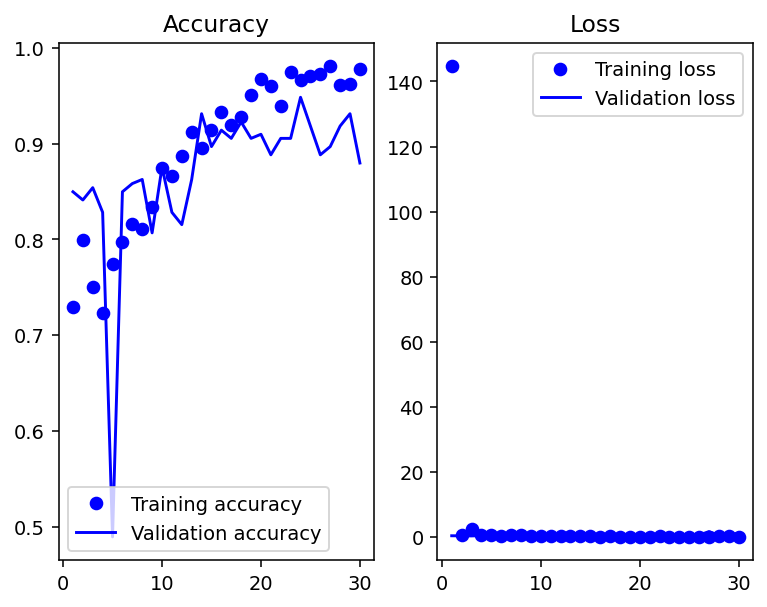

In [38]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140  # figure size vergroten

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(epochs, accuracy, "bo", label="Training accuracy")
ax1.plot(epochs, val_accuracy, "b", label="Validation accuracy")
ax1.set_title("Accuracy")
ax1.legend();

ax2.plot(epochs, loss, "bo", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.set_title("Loss")
ax2.legend();

In [39]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.8988 - loss: 0.3321
Test accuracy: 0.898


In [40]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

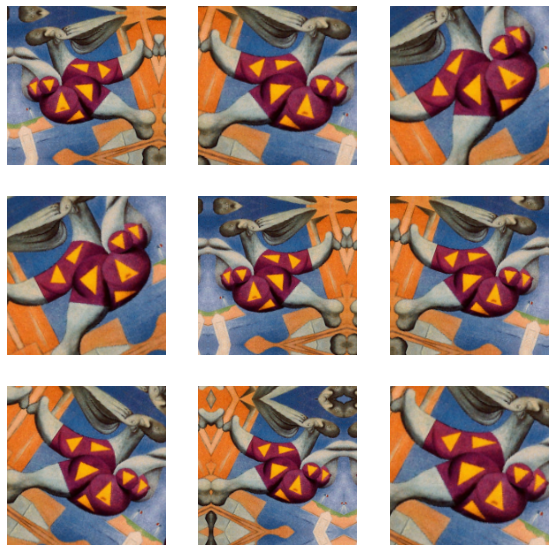

In [41]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 70  # figure size verkleinen
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [42]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)  # we voegen de data augmentation lagen toe aan ons model
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)  # we voegen een dropout laag toe
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [43]:
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

In [44]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch_with_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - accuracy: 0.7473 - loss: 0.7238 - val_accuracy: 0.8283 - val_loss: 0.4405
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.8112 - loss: 0.4952 - val_accuracy: 0.8283 - val_loss: 0.4886
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.8082 - loss: 0.5182 - val_accuracy: 0.8283 - val_loss: 0.3972
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.8220 - loss: 0.4347 - val_accuracy: 0.8283 - val_loss: 0.3892
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - accuracy: 0.8088 - loss: 0.4515 - val_accuracy: 0.8283 - val_loss: 0.3673
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.8252 - loss: 0.4106 - val_accuracy: 0.8283 - val_loss: 0.3438
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.8213 - loss: 0.4090 - val_accuracy: 0.8455 - val_loss: 0.3784
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.8350 - loss: 0.3879 - val_a

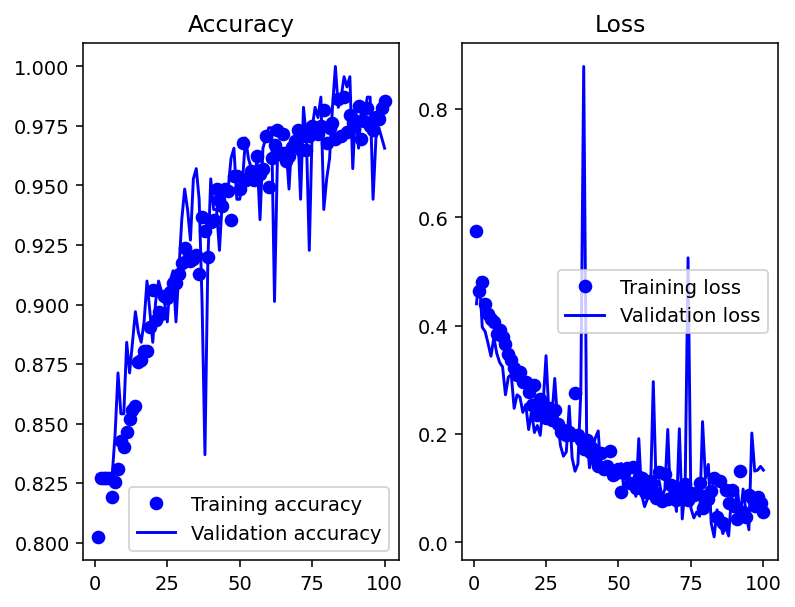

In [45]:
plt.rcParams['figure.dpi'] = 140  # figure size vergroten

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(epochs, accuracy, "bo", label="Training accuracy")
ax1.plot(epochs, val_accuracy, "b", label="Validation accuracy")
ax1.set_title("Accuracy")
ax1.legend();

ax2.plot(epochs, loss, "bo", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.set_title("Loss")
ax2.legend();

In [46]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9429 - loss: 0.2584
Test accuracy: 0.957


In [47]:
from tensorflow import keras

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [48]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [50]:
# Extract features using VGG16
print("Extracting features from training set...")
features_train, labels_train = get_features_and_labels(train_dataset)
print("Extracting features from validation set...")
features_val, labels_val = get_features_and_labels(validation_dataset)

# Build a simple classifier on top of VGG16 features
inputs = keras.Input(shape=features_train.shape[1:])
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
transfer_model = keras.Model(inputs, outputs)

# Compile the model
transfer_model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

# Train the classifier
transfer_history = transfer_model.fit(
    features_train, labels_train,
    epochs=20,
    batch_size=32,
    validation_data=(features_val, labels_val),
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath="transfer_model.keras",
            save_best_only=True,
            monitor="val_loss"
        )
    ]
)

Extracting features from training set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

In [51]:
# Create a complete model with VGG16 base for fine-tuning
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)  # Use your existing data_augmentation
x = keras.applications.vgg16.preprocess_input(x)

# Add the VGG16 base
conv_base.trainable = True
# Freeze early layers, only train the last few layers
for layer in conv_base.layers[:-4]:
    layer.trainable = False

x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
fine_tuned_model = keras.Model(inputs, outputs)

In [54]:
# Set up learning rate schedule
initial_learning_rate = 1e-4
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

# Compile with a lower learning rate for fine-tuning
fine_tuned_model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=lr_schedule),
    metrics=["accuracy"]
)

# Set up callbacks for training
fine_tuning_callbacks = [
    # Save best model
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuned_model.keras",
        save_best_only=True,
        monitor="val_loss"
    ),
    # Early stopping to prevent overfitting
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
]

# Train the fine-tuned model
fine_tuned_history = fine_tuned_model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=fine_tuning_callbacks
)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 235ms/step - accuracy: 0.7585 - loss: 1.5781 - val_accuracy: 0.9270 - val_loss: 0.3342
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.9026 - loss: 0.2615 - val_accuracy: 0.9528 - val_loss: 0.1332
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - accuracy: 0.9044 - loss: 0.2134 - val_accuracy: 0.9356 - val_loss: 0.1413
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - accuracy: 0.9312 - loss: 0.1625 - val_accuracy: 0.9657 - val_loss: 0.1109
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.9348 - loss: 0.1735 - val_accuracy: 0.9742 - val_loss: 0.0722
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.9616 - loss: 0.1239 - val_accuracy: 0.9785 - val_loss: 0.0978
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.9496 - loss: 0.1736 - val_accuracy: 0.9742 - val_loss: 0.0955
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - accuracy: 0.9725 - loss: 0.1021 - val_accuracy

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 299ms/step - accuracy: 0.9973 - loss: 0.0114
Final test accuracy: 0.996


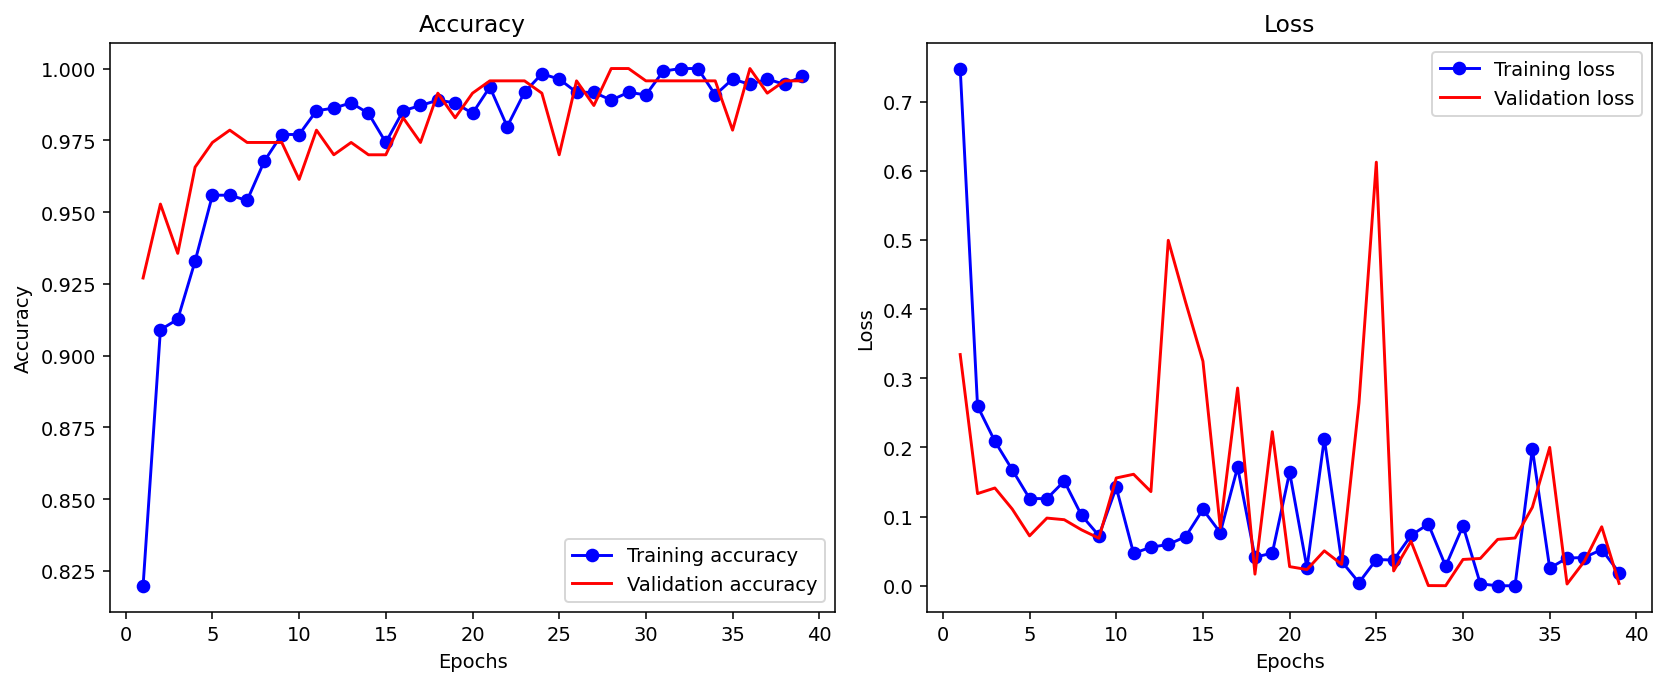

In [55]:
# Load and evaluate the fine-tuned model
best_model = keras.models.load_model("fine_tuned_model.keras")
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Final test accuracy: {test_acc:.3f}")

# Plot training history
plt.rcParams['figure.dpi'] = 140
accuracy = fine_tuned_history.history["accuracy"]
val_accuracy = fine_tuned_history.history["val_accuracy"]
loss = fine_tuned_history.history["loss"]
val_loss = fine_tuned_history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(epochs, accuracy, "bo-", label="Training accuracy")
ax1.plot(epochs, val_accuracy, "r-", label="Validation accuracy")
ax1.set_title("Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend()

ax2.plot(epochs, loss, "bo-", label="Training loss")
ax2.plot(epochs, val_loss, "r-", label="Validation loss")
ax2.set_title("Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()

plt.tight_layout()
plt.show()